In [38]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
import concurrent.futures

data1 = pd.read_excel(r'pcbi.1006752.s002.xlsx', sheet_name="Sheet1",index_col='Drug').drop('SMILES',axis=1)
data2 = pd.read_excel(r'583drugs39cell Zscore行标准化 synergy.xlsx')

 #顺序
temp1 = [] # 分子指纹合并值 【【】，【】，【】，】
index_1 = [] # 对应的名字列表 【【】，【】，【】，】
# 逆序
temp2 = []
index_2 = []
for index,row in data2.iterrows():
    ct = list((np.array(data1.loc[row["DrugA"],:])))
    ct.extend(list((np.array(data1.loc[row["DrugB"],:]))))
    temp1.append(ct)
    index_1.append((row["DrugA"],row["DrugB"]))
    ct = list((np.array(data1.loc[row["DrugB"],:])))
    ct.extend(list((np.array(data1.loc[row["DrugA"],:]))))
    temp2.append(ct)
    index_2.append((row["DrugB"],row["DrugA"]))

# 两组数据的tanimoto计算
def tanimoto(p,q):
    tep1=0
    tep2=0
    lenthp=int(len(p))
    for i in range(lenthp):
        a=p[i]
        b=q[i]
        if (a==1)|(b==1): # 并
            tep1=tep1+1
        if (a==1)&(b==1): # 交
            tep2=tep2+1
    c=round((tep2 / tep1),4)      #取值4位数
    return c

def compute_tanimoto(i, j, i_n, j_n, temp1, temp2, index_1, index_2, idx):
    tmp=[]
    a = np.array(i) #取出一分子指纹 转换列表为向量
    b = np.array(j)
    for k,m,k_n,m_n in zip(temp1,temp2,index_1,index_2): # 遍历每一个药物对的分子指纹
        c = np.array(k)
        d = np.array(m)
        tp1 = tanimoto(a,c)
        tp2 = tanimoto(a,d)
        tp3 = tanimoto(b,c)
        tp4 = tanimoto(b,d)
        tps = [tp1, tp2, tp3, tp4]
        index_list = [(i_n,k_n,tp1),(i_n,m_n,tp2),(j_n,k_n,tp3),(j_n,m_n,tp4)]
        index_location = tps.index(max(tps))
        tmp.append(max(tps))
        Tanimoto_index_dist[f"{i_n},{k_n}"] = index_list[index_location]
    return idx, tmp

temp = [None] * len(temp1)
Tanimoto_index_dist = {}
with concurrent.futures.ThreadPoolExecutor() as executor:
    # 提交任务时使用 enumerate ，并将索引值作为参数传递给任务函数
    futures = [executor.submit(compute_tanimoto, i, j, i_n, j_n, temp1, temp2, index_1, index_2, idx)
               for idx, (i,j,i_n,j_n) in enumerate(zip(temp1,temp2,index_1,index_2))]
    for future in concurrent.futures.as_completed(futures):
        idx, result = future.result()
        temp[idx] = result
Tanimoto = pd.DataFrame(temp, columns=index_1, index=index_1)

tptp = Tanimoto.copy()
dpdp = Tanimoto.copy()

gl = 0.52
# 筛高相似
while True:
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in tptp.values:
        cot = 0
        for j in i:
            if j < gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1

    # 取出对应行
    count = 0
    for i in tptp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1

    # 取出对应列
    drop_l_list = []
    for i in tptp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1

    h = np.array(drop_h_list).copy()
    l = np.array(drop_l_list).copy()
    h[h < gl] = 10000
    l[l < gl] = 10000
    if np.sum(h) >= np.sum(l):
        tptp.drop(index=[tptp.columns[drop_h]], columns=[tptp.columns[drop_h]], inplace=True)
    elif np.sum(h) < np.sum(l):
        tptp.drop(index=[tptp.columns[drop_l]], columns=[tptp.columns[drop_l]], inplace=True)

    p = np.array(tptp.values).copy()
    p[p < gl] = 582 * 582
    if np.sum(p) < 582 * 582:
        break

gl = 0.52
# 筛低相似
while True:
    dpdp[dpdp == 1] = -1
    drop_status = 0
    count = 0
    drop_h = 0
    drop_l = 0
    for i in dpdp.values:
        cot = 0
        for j in i:
            if j > gl:
                drop_h = count
                drop_l = cot
                drop_status = 1
                break
            cot += 1
        if drop_status == 1:
            break
        count += 1

    # 取出对应行
    count = 0
    drop_h_list = []
    for i in dpdp.values:
        if count == drop_h:
            drop_h_list = i
            break
        count += 1

    # 取出对应列
    drop_l_list = []
    for i in dpdp.values:
        cot = 0
        for j in i:
            if cot == drop_l:
                drop_l_list.append(j)
            cot += 1

    h = np.array(drop_h_list).copy()
    l = np.array(drop_l_list).copy()
    h[h > gl] = 10000
    l[l > gl] = 10000
    if np.sum(h) >= np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_h]], columns=[dpdp.columns[drop_h]], inplace=True)
    elif np.sum(h) < np.sum(l):
        dpdp.drop(index=[dpdp.columns[drop_l]], columns=[dpdp.columns[drop_l]], inplace=True)
    p = np.array(dpdp.values).copy()
    p[p > gl] = 39 * 39
    if np.sum(p) < 39 * 39:
        break
dpdp[dpdp == -1] = 1

/root/miniconda3/envs/jupyter-env/lib/python3.10/site-packages/openpyxl/worksheet/_read_only.py:79: UserWarning: Unknown extension is not supported and will be removed
  for idx, row in parser.parse():


In [39]:
tptp

,"(SUNITINIB, MK-2206)","(MK-2206, DINACICLIB)","(VINORELBINE, DINACICLIB)","(SUNITINIB, MK-4827)","(MK-2206, TOPOTECAN)","(AZD1775, MK-4827)","(VINORELBINE, DASATINIB)","(ABT-888, SN-38)","(VINBLASTINE, MK-4827)","(MITOMYCINE, MK-2206)","(VINBLASTINE, AZD1775)"
"(SUNITINIB, MK-2206)",1.0000,0.6838,0.5570,0.7805,0.7164,0.5608,0.5370,0.5390,0.5753,0.7059,0.5912
"(MK-2206, DINACICLIB)",0.6838,1.0000,0.6846,0.5238,0.6906,0.5946,0.5301,0.5310,0.5772,0.6345,0.5926
"(VINORELBINE, DINACICLIB)",0.5570,0.6846,1.0000,0.5855,0.6051,0.6115,0.7947,0.5519,0.7500,0.5776,0.7516
"(SUNITINIB, MK-4827)",0.7805,0.5238,0.5855,1.0000,0.5517,0.7121,0.5844,0.5704,0.7308,0.5442,0.5696
"(MK-2206, TOPOTECAN)",0.7164,0.6906,0.6051,0.5517,1.0000,0.5906,0.5839,0.7023,0.6620,0.7630,0.6710
"(AZD1775, MK-4827)",0.5608,0.5946,0.6115,0.7121,0.5906,1.0000,0.6101,0.5664,0.7820,0.5321,0.7333
"(VINORELBINE, DASATINIB)",0.5370,0.5301,0.7947,0.5844,0.5839,0.6101,1.0000,0.5714,0.7466,0.5576,0.7595
"(ABT-888, SN-38)",0.5390,0.5310,0.5519,0.5704,0.7023,0.5664,0.5714,1.0000,0.6642,0.5734,0.5974
"(VINBLASTINE, MK-4827)",0.5753,0.5772,0.7500,0.7308,0.6620,0.7820,0.7466,0.6642,1.0000,0.5867,0.7740
"(MITOMYCINE, MK-2206)",0.7059,0.6345,0.5776,0.5442,0.7630,0.5321,0.5576,0.5734,0.5867,1.0000,0.6012


In [40]:
tptp.shape

(11, 11)

In [41]:
dpdp

,"(MK-4827, MK-8776)","(CYCLOPHOSPHAMIDE, BEZ-235)","(METFORMIN, BEZ-235)","(ZOLINZA, AZD1775)","(MRK-003, PACLITAXEL)","(DEXAMETHASONE, MK-8669)","(ABT-888, SN-38)","(MK-4541, ETOPOSIDE)","(CARBOPLATIN, DINACICLIB)","(PD325901, SORAFENIB)","(BORTEZOMIB, OXALIPLATIN)","(ERLOTINIB, GELDANAMYCIN)","(METHOTREXATE, TEMOZOLOMIDE)"
"(MK-4827, MK-8776)",1.0000,0.4412,0.3281,0.4789,0.3681,0.2909,0.4610,0.3203,0.3971,0.3624,0.3481,0.3245,0.4928
"(CYCLOPHOSPHAMIDE, BEZ-235)",0.4412,1.0000,0.5185,0.5111,0.4091,0.3185,0.4184,0.4000,0.3333,0.4275,0.3134,0.3288,0.4815
"(METFORMIN, BEZ-235)",0.3281,0.5185,1.0000,0.3906,0.2484,0.2067,0.3488,0.2593,0.3167,0.2955,0.2605,0.3023,0.4380
"(ZOLINZA, AZD1775)",0.4789,0.5111,0.3906,1.0000,0.3916,0.4167,0.4558,0.3636,0.4887,0.4965,0.4394,0.4345,0.4861
"(MRK-003, PACLITAXEL)",0.3681,0.4091,0.2484,0.3916,1.0000,0.4356,0.4367,0.4867,0.3882,0.3494,0.3097,0.4351,0.3841
"(DEXAMETHASONE, MK-8669)",0.2909,0.3185,0.2067,0.4167,0.4356,1.0000,0.4183,0.5000,0.3581,0.3631,0.3688,0.4552,0.3152
"(ABT-888, SN-38)",0.4610,0.4184,0.3488,0.4558,0.4367,0.4183,1.0000,0.4610,0.4058,0.3709,0.3881,0.4167,0.4789
"(MK-4541, ETOPOSIDE)",0.3203,0.4000,0.2593,0.3636,0.4867,0.5000,0.4610,1.0000,0.3287,0.3904,0.3000,0.4925,0.3733
"(CARBOPLATIN, DINACICLIB)",0.3971,0.3333,0.3167,0.4887,0.3882,0.3581,0.4058,0.3287,1.0000,0.3172,0.4167,0.4030,0.3857
"(PD325901, SORAFENIB)",0.3624,0.4275,0.2955,0.4965,0.3494,0.3631,0.3709,0.3904,0.3172,1.0000,0.3864,0.4056,0.4577


In [42]:
dpdp.shape


(13, 13)

/tmp/ipykernel_347464/2840162697.py:63: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for index, line in result_compare.iteritems():


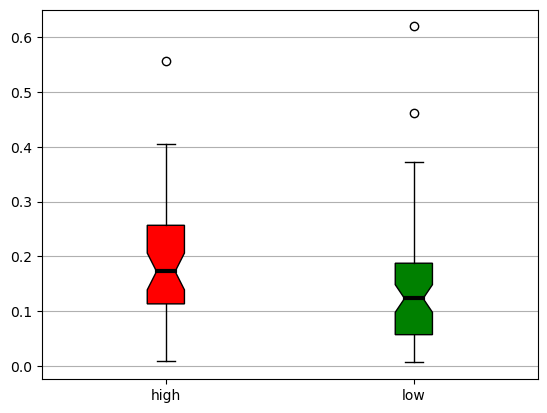

AxesSubplot(0.125,0.11;0.775x0.77)


In [43]:
high_similar_regiments=tptp
low_similar_regiments=dpdp
drugs_data=data2.T
drugs_data.columns=Tanimoto.index
drugs_data=drugs_data.drop('DrugA',axis=0).drop('DrugB',axis=0)

high_midecines = high_similar_regiments.columns[1:]
low_midecines = low_similar_regiments.columns[1:]

drugs_temp = []
j = 0
for i in drugs_data.columns[0:]:
    drugs_temp.append(drugs_data[i])
    j += 1

#预处理drugs
t = drugs_temp[0]
for i in drugs_temp[1:]:
    t = pd.concat([t,i],axis=1)
drugs = t.copy()
#drugs

#zscore标准化
values = drugs.values            #Dataframe转换为Array
values = values.astype('float32')       #定义数据类型
scaler = preprocessing.StandardScaler() #创建Scaler对象
temp = scaler.fit_transform(values)     #稀疏矩阵
drugs=pd.DataFrame(temp,columns=drugs.columns) #将Array还原为Dataframe，保持行列名

#提取药物对对应高相似团
high_list = []
for i in high_midecines:
    high_list.append(drugs[i])
r = high_list[0]
for i in high_list[1:]:
    r = pd.concat([r,i],axis=1)
high_result = r
#print(high_list)

#提取药物对对应低相似团
low_list = []
for i in low_midecines:
    low_list.append(drugs[i])
r = low_list[0]
for i in low_list[1:]:
    r = pd.concat([r,i],axis=1)
low_result = r
#print(low_list)

#计算高相似细胞团的斯皮尔曼相关性系数
spearman_h=high_result.corr('spearman')
#计算低相似细胞团的斯皮尔曼相关性系数
spearman_l=low_result.corr('spearman')

arr1 = np.triu(np.array(spearman_h),k=1)
arr2 = np.triu(np.array(spearman_l),k=1)

#取非零元素
high_res = np.abs(arr1.ravel()[np.flatnonzero(arr1)])
low_res = np.abs(arr2.ravel()[np.flatnonzero(arr2)])
result_compare = pd.DataFrame([high_res.T,low_res.T],index=['high','low']).T
result_compare_lst = []
for index, line in result_compare.iteritems():
    result_compare_lst.append(np.array(line.dropna()))
fig = plt.subplot(1, 1, 1)
bplot = fig.boxplot(result_compare_lst,
                    meanline='black',
                    notch=True,
                    vert=True,
                    patch_artist=True)
# 颜色填充
colors = ['red', 'green']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)

for median in bplot['medians']:
    median.set(color='black', linewidth=3)

fig.yaxis.grid(True)  # 在y轴上添加网格线
fig.set_xticks([y + 1 for y in range(len(result_compare_lst))])
# fig.set_xlabel('细胞团') #设置x轴名称
# fig.set_ylabel('ylabel') #设置y轴名称

# 添加刻度
# 添加刻度名称，我们需要使用 plt.setp() 函数：

# 加刻度名称
plt.setp(fig, xticks=[1, 2],
         xticklabels=['high', 'low'])
# 我们的刻度数是哪些，以及我们想要它添加的刻度标签是什么。
plt.savefig('f2.jpg')

plt.show()

print(fig)
# import csv

# data_transposed = np.transpose(result_compare_lst)

# # Write the transposed data to CSV files
# with open('array1.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for row in data_transposed[0]:
#         writer.writerow([np.abs(row)])

# with open('array2.csv', 'w', newline='') as f:
#     writer = csv.writer(f)
#     for row in data_transposed[1]:
#         writer.writerow([np.abs(row)])

In [44]:
result_compare_lst

[array([0.20060729, 0.0097166 , 0.11093117, 0.25688259, 0.20465587,
        0.01315789, 0.02874494, 0.11639676, 0.08522267, 0.14473684,
        0.28421053, 0.37044534, 0.2208502 , 0.27246964, 0.24878543,
        0.22550607, 0.13805668, 0.14230769, 0.00951417, 0.15688259,
        0.20506073, 0.28481781, 0.10890688, 0.10242915, 0.40566802,
        0.11639676, 0.36437247, 0.14979757, 0.55708502, 0.14210526,
        0.23198381, 0.32307692, 0.13218623, 0.18076923, 0.16295547,
        0.11356275, 0.17267206, 0.17692308, 0.06680162, 0.28927126,
        0.30850202, 0.25647773, 0.03744939, 0.31578947, 0.03157895]),
 array([0.6194332 , 0.12995951, 0.21781377, 0.13927126, 0.02813765,
        0.32510121, 0.04797571, 0.1791498 , 0.32651822, 0.03461538,
        0.00668016, 0.04271255, 0.05526316, 0.03279352, 0.37307692,
        0.20951417, 0.13623482, 0.11336032, 0.46255061, 0.07834008,
        0.09615385, 0.04392713, 0.22327935, 0.05728745, 0.18663968,
        0.02510121, 0.08846154, 0.10242915, 0.